In [3]:
import time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [5]:
#read in terrorism dataset
terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")

#output the first five rows to see if the file read in correctly- IT DID!
terrorism.head()

C:\Users\ryanc\AppData\Local\Temp\ipykernel_23224\14693481.py:2: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [6]:
#only include those terrorist attacks that met the three criteria listed in the codebook
mask = (terrorism['crit1'] == 1) & (terrorism['crit3'] == 1) & (terrorism['crit3'] == 1)
terrorism = terrorism[mask].drop(columns = ['crit1', 'crit2', 'crit3'])
terrorism.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Preparing the dataset...
Dataset split completed.
Subset size: 50000 rows

--- Starting Halving Grid Search for Linear Kernel ---
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 6250
max_resources_: 50000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 6250
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 4
n_resources: 12500
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 25000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 3
n_candidates: 1
n_resources: 50000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Halving Grid Search completed in 2810.79 seconds
Best Parameters: {'svc__C': 0.1}
Best Cross-Validation Accuracy: 0.48
Optimizing threshold using logistic regression...
Optimal Threshold (Linear Kernel): 0.68

Performance at Logistic Regression-Optimized Threshold:
Precision: 0.6658
Recall: 0.7463
F1 Score: 0.7038


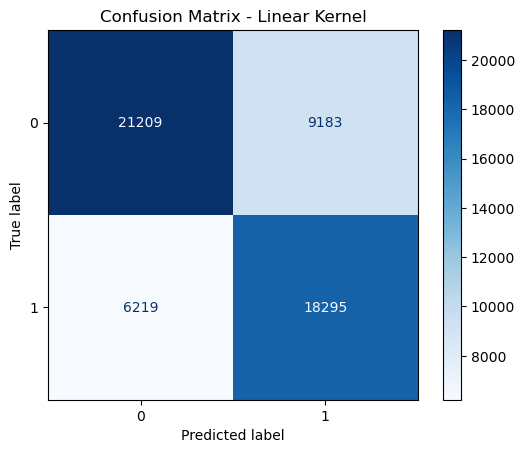

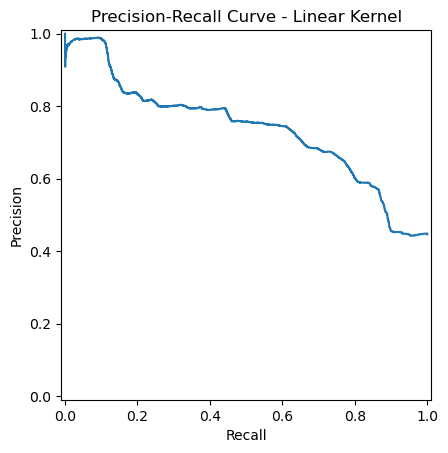

In [105]:
# Linear Kernel Code
print("Preparing the dataset...")
# Preprocessing Pipeline
numerical_columns = ['nkillter', 'nwound', 'iyear', 'suicide', 'extended', 'success']
categorical_columns = ['attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'region_txt']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_columns)
    ]
)

# Create the target variable
terrorism['civilian_deaths'] = terrorism['nkill'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

# Split the dataset
X = terrorism[numerical_columns + categorical_columns]
y = terrorism['civilian_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Dataset split completed.")

# Subset for Training
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42, stratify=y_train
)
print(f"Subset size: {X_train_subset.shape[0]} rows")

# Linear Kernel Pipeline
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='linear', probability=True, random_state=42, max_iter=5000))
])

# Halving Grid Search
param_grid_linear = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
halving_grid_search_linear = HalvingGridSearchCV(
    pipeline_linear, param_grid=param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=3, factor=2
)

print("\n--- Starting Halving Grid Search for Linear Kernel ---")
start_time = time.time()
halving_grid_search_linear.fit(X_train_subset, y_train_subset)
end_time = time.time()
print(f"Halving Grid Search completed in {end_time - start_time:.2f} seconds")
print(f"Best Parameters: {halving_grid_search_linear.best_params_}")
print(f"Best Cross-Validation Accuracy: {halving_grid_search_linear.best_score_:.2f}")

# Best Model and Predictions
best_linear_model = halving_grid_search_linear.best_estimator_
y_pred_proba = best_linear_model.predict_proba(X_test)[:, 1]

# Logistic Regression for Threshold Optimization
print("Optimizing threshold using logistic regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(y_pred_proba.reshape(-1, 1), y_test)

# Predict probabilities for the optimal threshold
thresholds = np.linspace(0.1, 0.99, 50)
precision_scores, recall_scores, f1_scores = [], [], []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Linear Kernel): {optimal_threshold:.2f}")

# Evaluate at Optimal Threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)

print("\nPerformance at Logistic Regression-Optimized Threshold:")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")

# Confusion Matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=best_linear_model.named_steps['svc'].classes_)
disp_optimal.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Linear Kernel")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve - Linear Kernel")
plt.show()

Analyzing column: nkillter


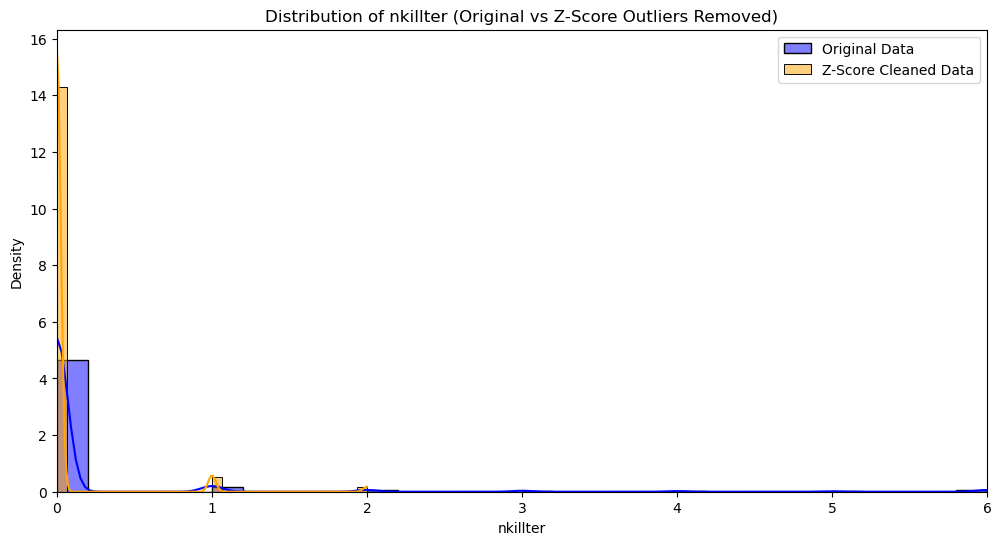

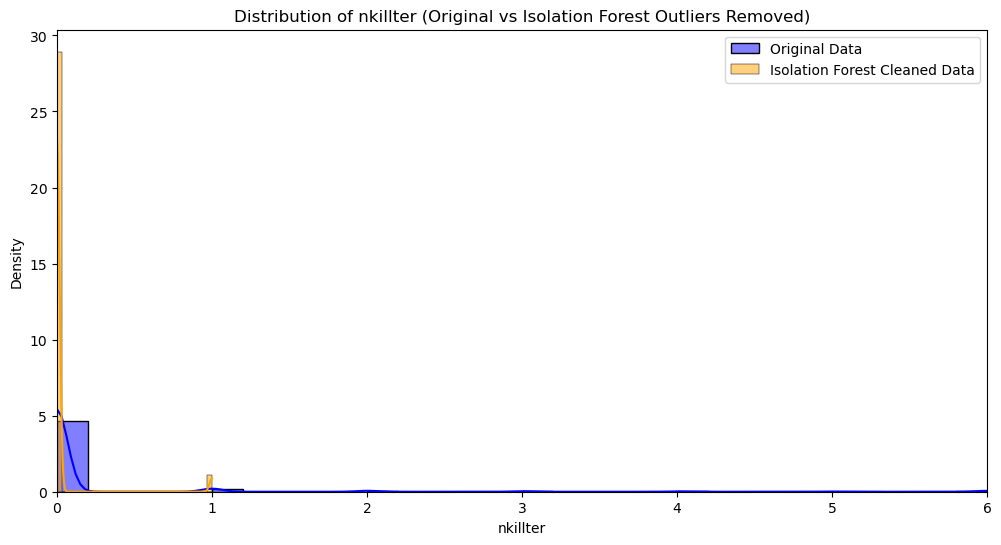

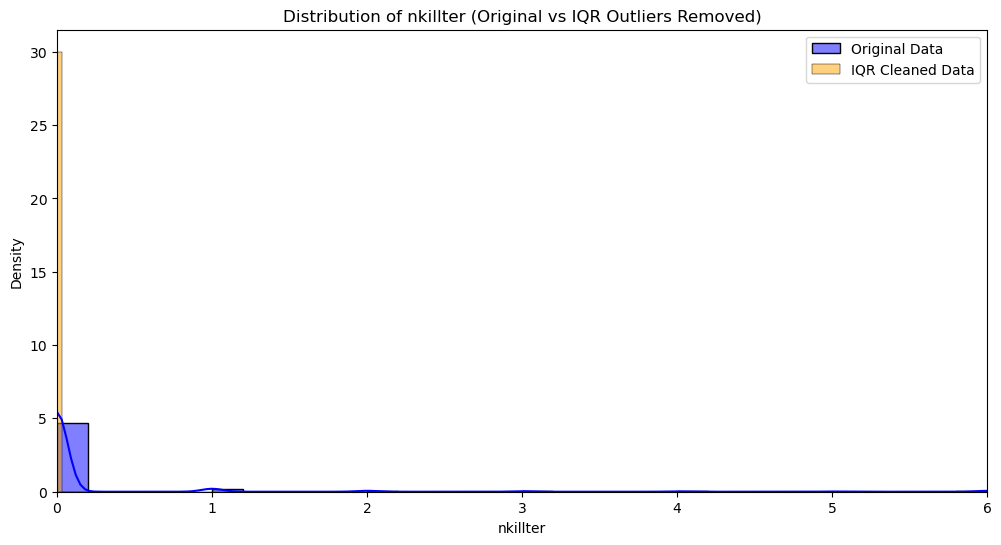

Analyzing column: nwound


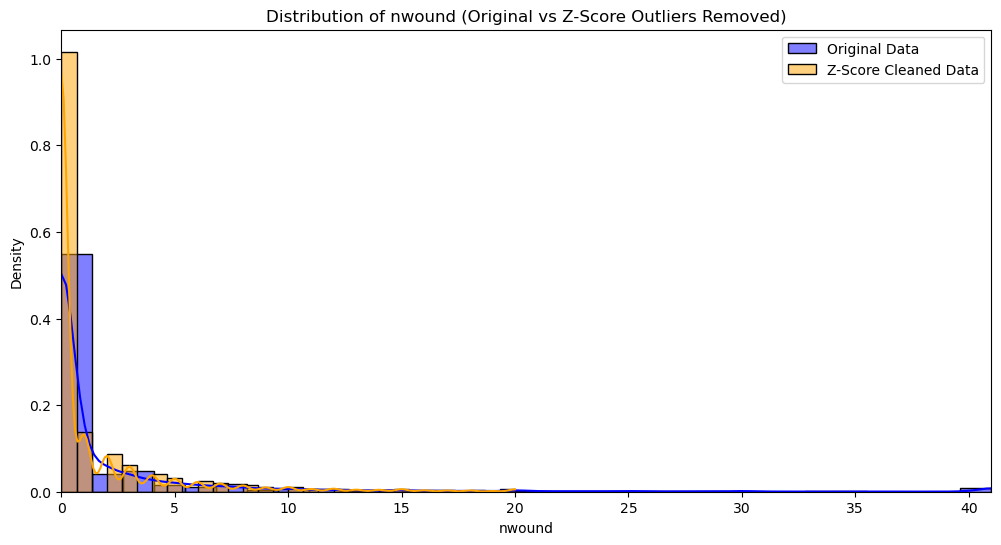

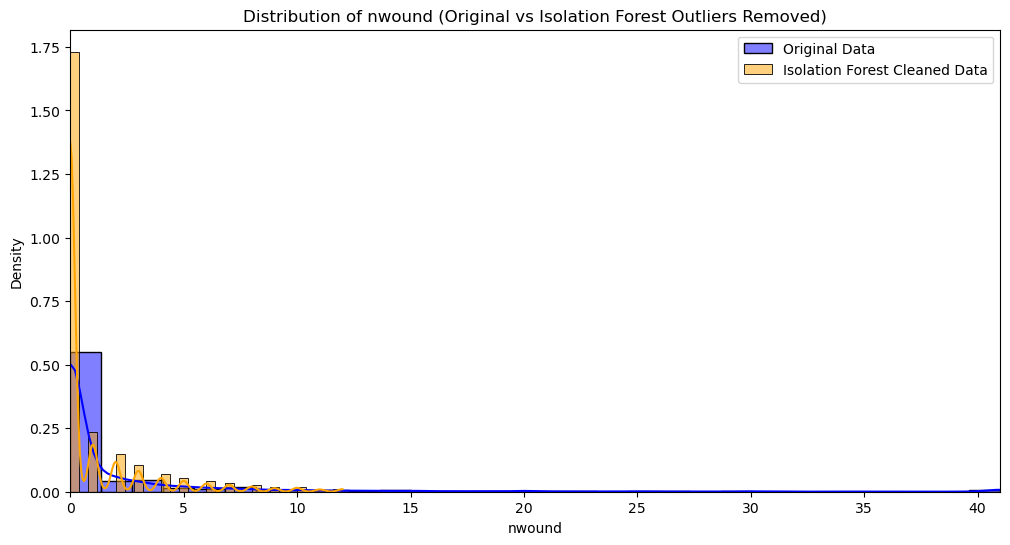

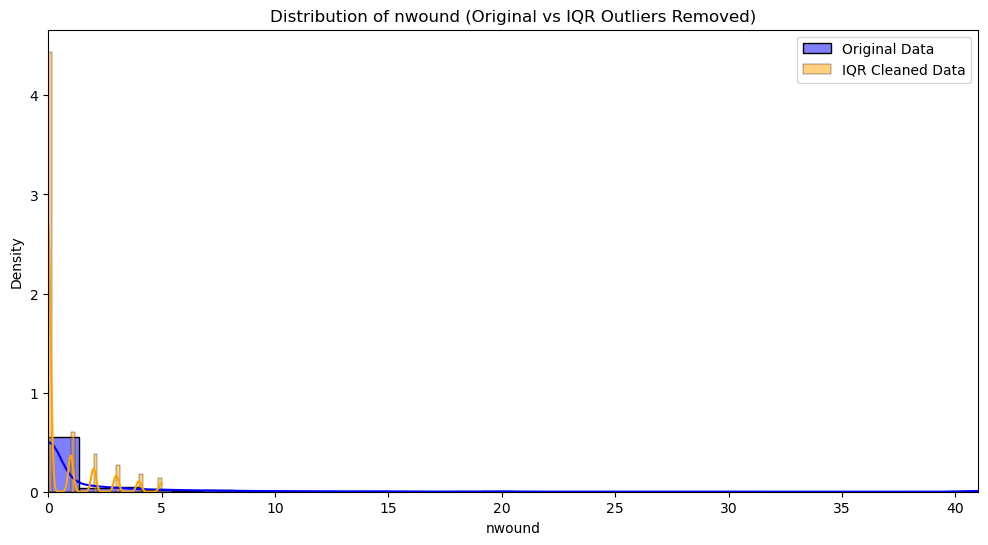

Analyzing column: iyear


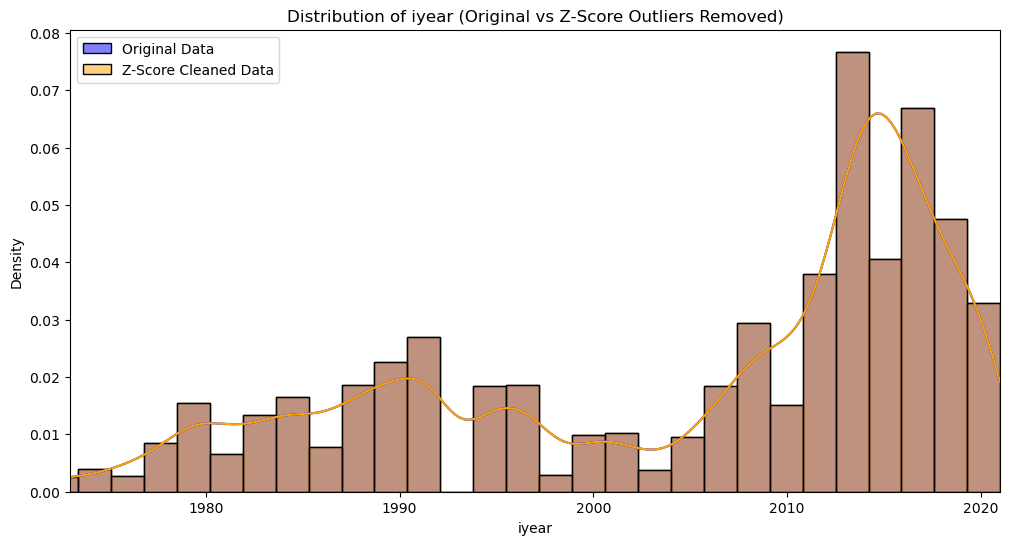

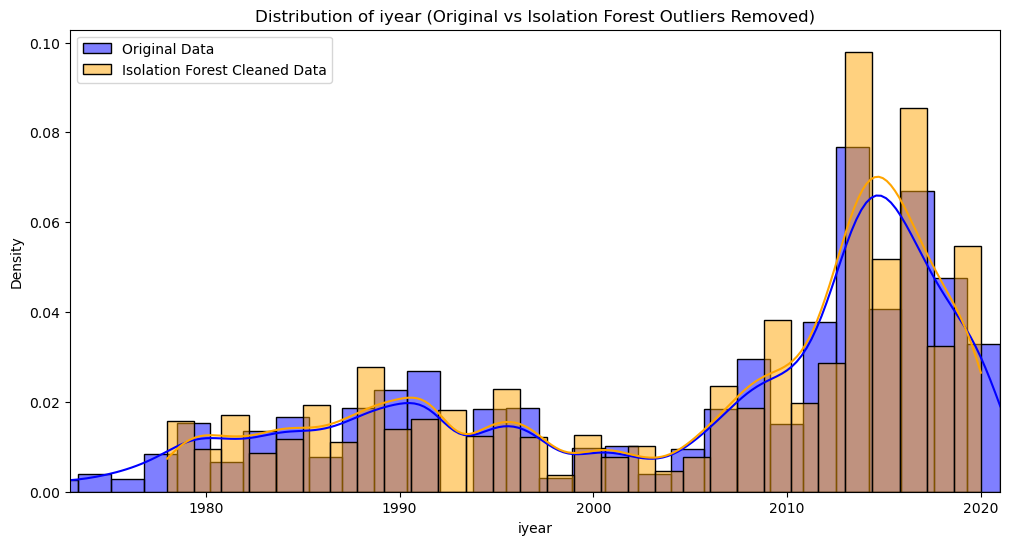

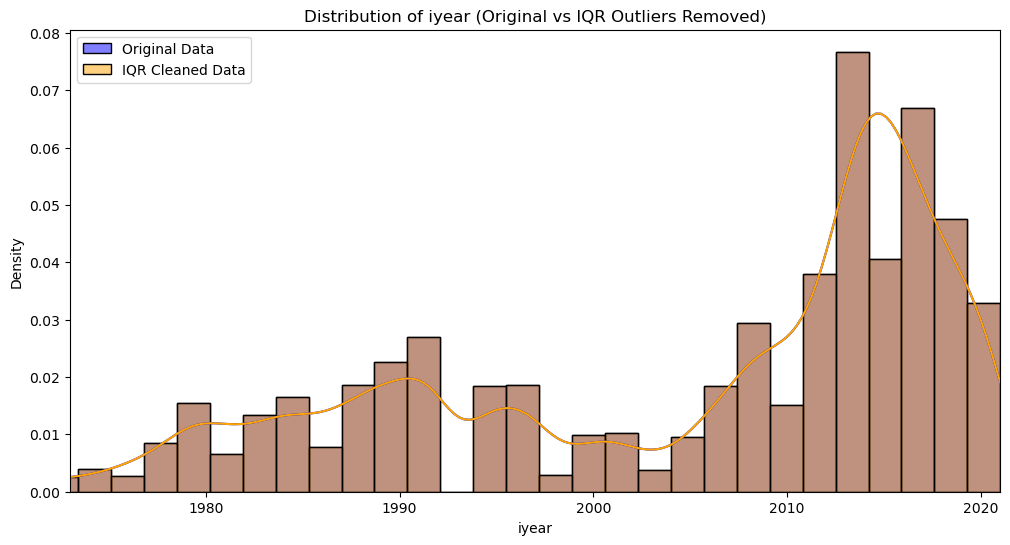

Analyzing column: suicide


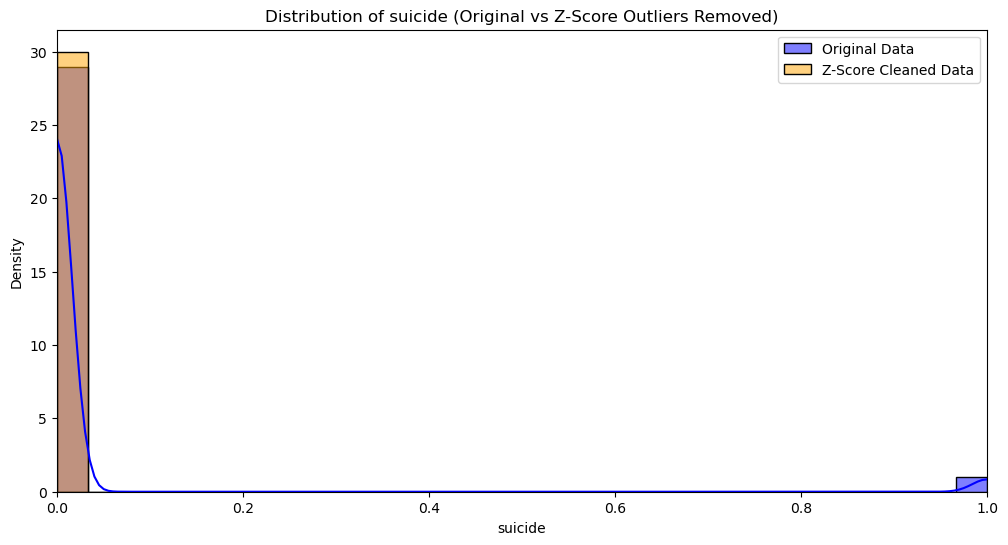

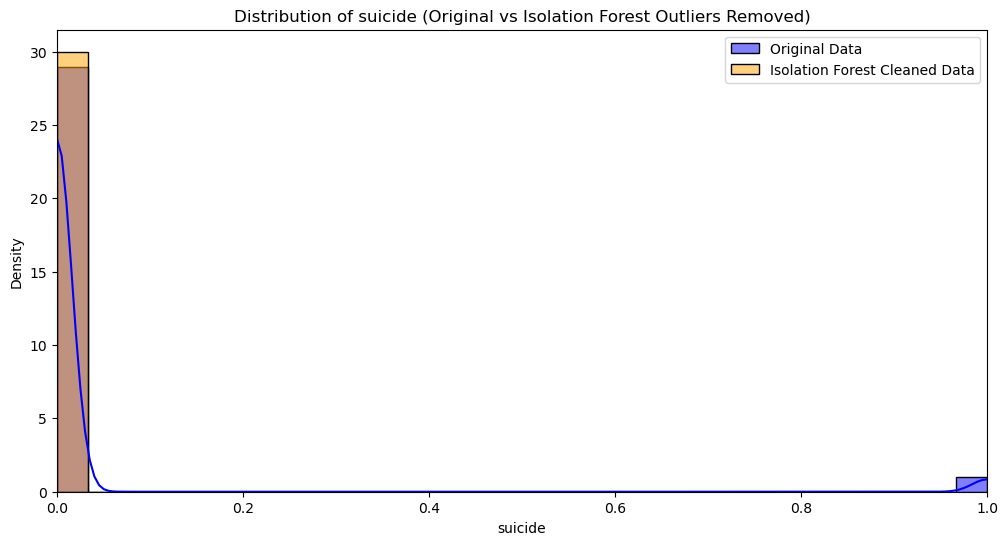

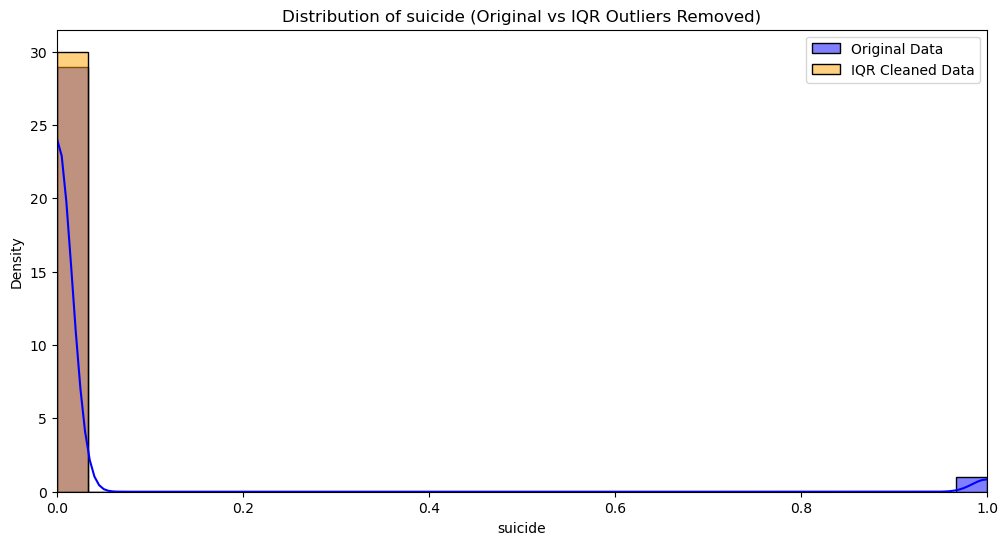

Analyzing column: extended


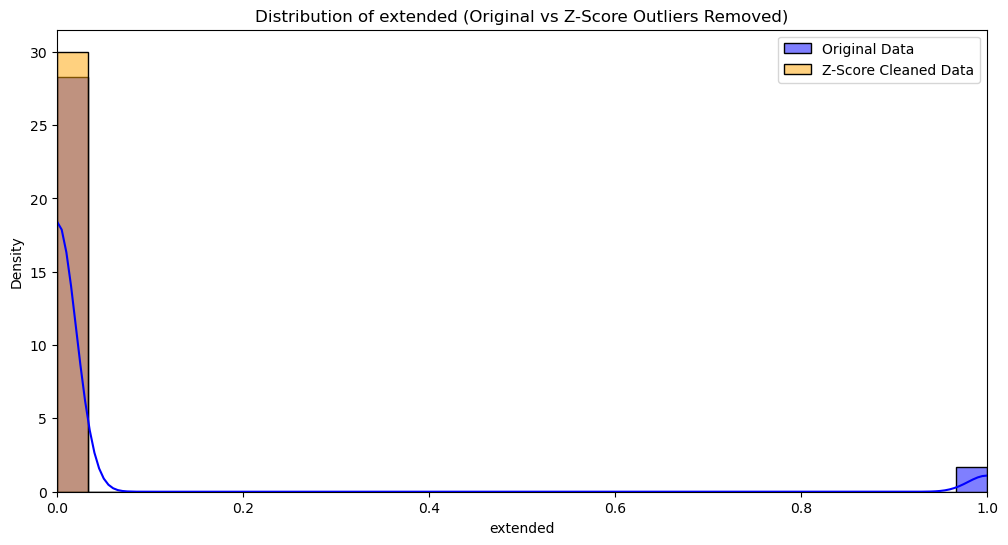

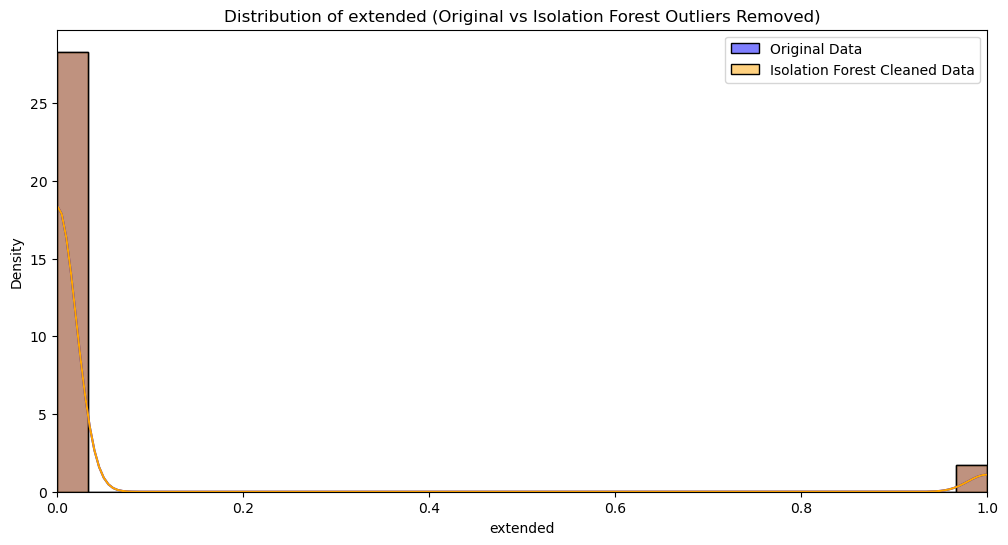

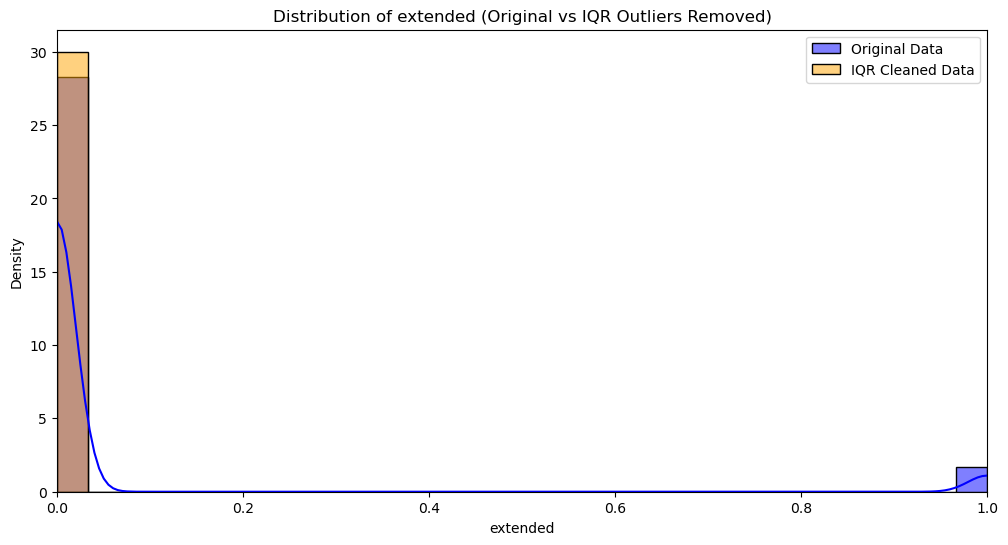

Analyzing column: success


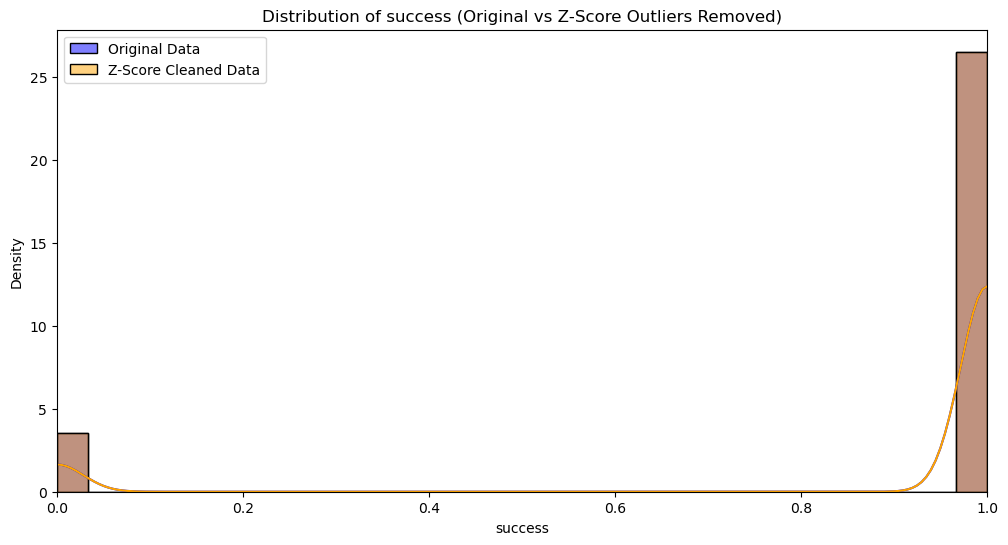

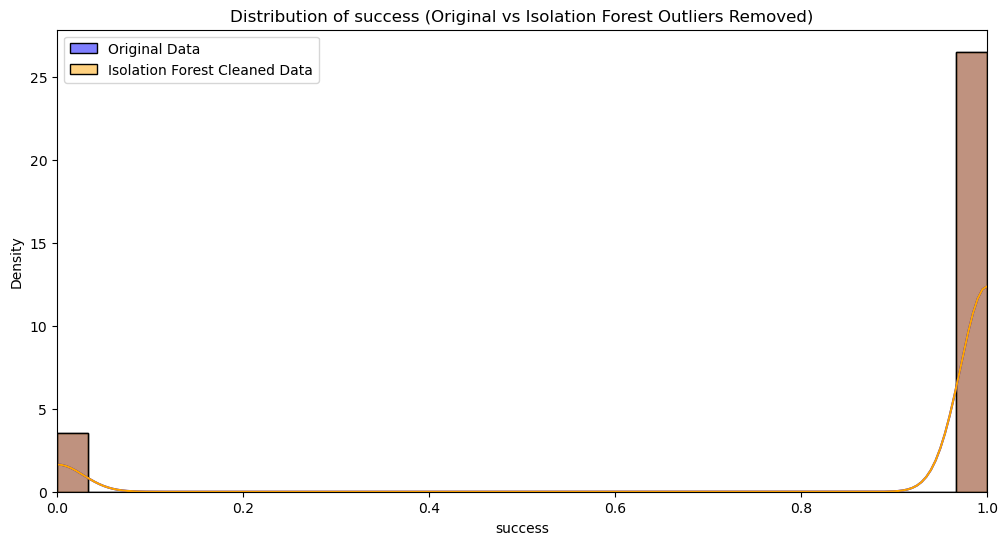

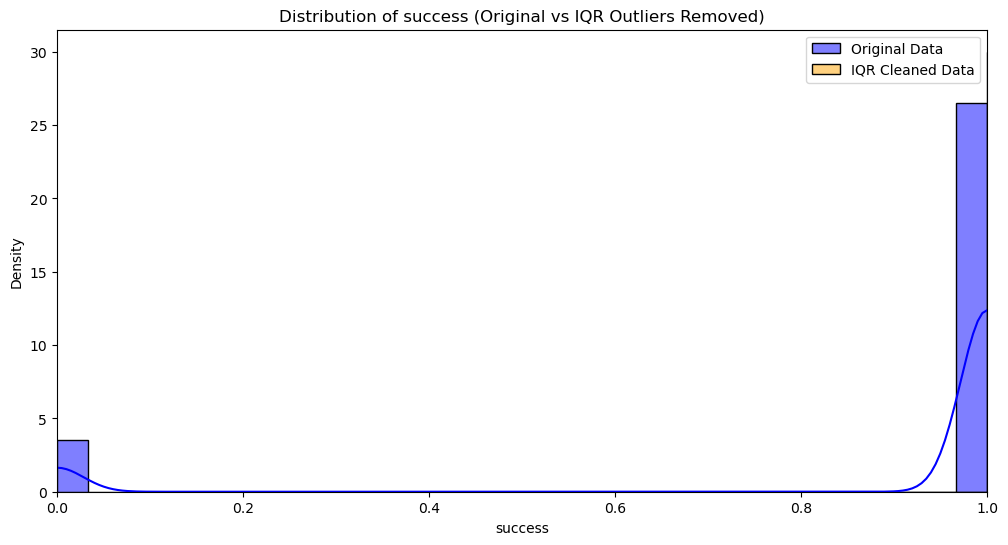

In [15]:
#Outlier analysis
# Function to plot distributions before and after removing outliers
def plot_distributions(data, column, cleaned_data, method_name):
    plt.figure(figsize=(12, 6))
    
    # Calculate x-axis limits dynamically
    lower_limit = data[column].quantile(0.01)  # 1st percentile
    upper_limit = data[column].quantile(0.99)  # 99th percentile
    
    # Plot original and cleaned data distributions
    sns.histplot(data[column], bins=30, kde=True, label='Original Data', color='blue', stat="density")
    sns.histplot(cleaned_data[column], bins=30, kde=True, label=f'{method_name} Cleaned Data', color='orange', stat="density")
    
    # Adjust x-axis limits
    plt.xlim(lower_limit, upper_limit)
    
    # Add plot labels and title
    plt.title(f"Distribution of {column} (Original vs {method_name} Outliers Removed)")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Z-Score Method
def remove_outliers_zscore(data, column, threshold=3):
    data = data.copy()
    z_scores = zscore(data[column])
    abs_z_scores = np.abs(z_scores)
    return data[abs_z_scores < threshold]

# Isolation Forest Method
def remove_outliers_isolation_forest(data, column):
    data = data.copy()
    iso = IsolationForest(contamination=0.05, random_state=42)
    is_outlier = iso.fit_predict(data[[column]])
    return data[is_outlier == 1]

# IQR Method
def remove_outliers_iqr(data, column):
    data = data.copy()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply outlier analysis for each numerical column
for column in numerical_columns:
    print(f"Analyzing column: {column}")
    
    # Original data distribution
    original_data = terrorism[[column]].dropna()
    
    # Z-Score Method
    cleaned_zscore = remove_outliers_zscore(terrorism, column)
    plot_distributions(original_data, column, cleaned_zscore, "Z-Score")
    
    # Isolation Forest Method
    cleaned_iso = remove_outliers_isolation_forest(terrorism, column)
    plot_distributions(original_data, column, cleaned_iso, "Isolation Forest")
    
    # IQR Method
    cleaned_iqr = remove_outliers_iqr(terrorism, column)
    plot_distributions(original_data, column, cleaned_iqr, "IQR")